In [191]:
import pandas as pd
import pickle 
import re

from scipy.spatial.distance import cosine
from gensim.models import FastText

import sys
sys.path.append('../code')

from preprocessing import GlowpickPreprocessing

# Load data

In [6]:
reviews = pd.read_csv('../dataset/glowpick_reviews.csv')
products = pd.read_csv('../dataset/glowpick_products.csv')
print('reviews.shape: ',reviews.shape)
print('products.shape: ',products.shape)

reviews.shape:  (461659, 7)
products.shape:  (12698, 9)


# Load saved file

In [8]:
text = pickle.load(open('../saved_file/new_pre_text.pickle','rb'))
text_word = pickle.load(open('../saved_file/new_pre_text_word.pickle','rb'))
text_pos = pickle.load(open('../saved_file/new_pre_text_pos.pickle','rb'))
text_word_pos = pickle.load(open('../saved_file/new_pre_text_word_pos.pickle','rb'))

In [9]:
vec = pickle.load(open('../saved_file/new_pre_embed.pickle','rb'))
vec_word = pickle.load(open('../saved_file/new_pre_embed_word.pickle','rb'))
vec_pos = pickle.load(open('../saved_file/new_pre_embed_pos.pickle','rb'))
vec_word_pos = pickle.load(open('../saved_file/new_pre_embed_word_pos.pickle','rb'))

In [10]:
model = FastText.load('../saved_file/new_model.bin')
model_word = FastText.load('../saved_file/new_model_word.bin')
model_pos = FastText.load('../saved_file/new_model_pos.bin')
model_word_pos = FastText.load('../saved_file/new_model_word_pos.bin')

# Test

In [11]:
wordpath = '../saved_file/replace_word.json'
pospath = '../saved_file/pos_dict.json'

In [259]:
search = ['향 좋은 핸드크림']

In [260]:
GP = GlowpickPreprocessing()
s_text = GP.fit(search)
s_text_word = GP.fit(search, wordfix_path=wordpath)
s_text_pos = GP.fit(search, posfix_path=pospath)
s_text_word_pos = GP.fit(search, wordfix_path=wordpath, posfix_path=pospath)

s_vec = GP.sent2vec(s_text, model)
s_vec_word = GP.sent2vec(s_text_word, model_word)
s_vec_pos = GP.sent2vec(s_text_pos, model_pos)
s_vec_word_pos = GP.sent2vec(s_text_word_pos, model_word_pos)

[PREPROCESSING]: complete stopword
Loading JIT Compiled ChatSpace Model
[PREPROCESSING]: complete spacefix
[PREPROCESSING]: complete stopword
Loading JIT Compiled ChatSpace Model
[PREPROCESSING]: complete spacefix
[PREPROCESSING]: complete wordfix
[PREPROCESSING]: complete stopword
Loading JIT Compiled ChatSpace Model
[PREPROCESSING]: complete spacefix
[PREPROCESSING]: complete posfix
[PREPROCESSING]: complete stopword
Loading JIT Compiled ChatSpace Model
[PREPROCESSING]: complete spacefix
[PREPROCESSING]: complete wordfix
[PREPROCESSING]: complete posfix


In [292]:
print('s_text: ',s_text)

s_text:  [['향', '좋은', '핸드크림']]


# Filtering

In [261]:
# feature selection
features = ['product_url','category','brand','vol_price','nb_reviews','sex','age_skin_type','rate_x','product','content']
show_features = ['category','brand','nb_reviews','vol_price','product']

# filtering 여성용품
if '여성용품' in products.title.unique():
    print('[LOAD] filtering data')
    data_prod = pd.merge(reviews, products, on='product_url', how='left')

    male_cosmetic = data_prod[data_prod.title=='남성화장품']
    male_reviews = data_prod[(data_prod.title!='남성화장품')&(data_prod.sex=='m')]

    reviews = pd.concat([male_cosmetic, male_reviews], axis=0)

    # rate_x -> rate
    reviews = reviews.rename(columns={'rate_x':'rate'})
    reviews = reviews[['user_id','sex','age_skin_type','rate','content','product_url']].drop_duplicates()
    print('filtering reviews shape: ',reviews.shape)

[LOAD] filtering data
filtering reviews shape:  (10390, 6)


# distance

In [262]:
def cosine_dist(m, v):
    dist_arr = np.zeros((m.shape[0]))
    for i, sent in enumerate(m):
        dist = cosine(sent, v[0])
        dist_arr[i] = dist
    return dist_arr

In [263]:
dist = cosine_dist(vec, s_vec)
dist_word = cosine_dist(vec_word, s_vec_word)
dist_pos = cosine_dist(vec_pos, s_vec_pos)
dist_word_pos = cosine_dist(vec_word_pos, s_vec_word_pos)

In [264]:
reviews['dist'] = dist
reviews['dist_word'] = dist_word
reviews['dist_pos'] = dist_pos
reviews['dist_word_pos'] = dist_word_pos

In [320]:
reviews_prod = pd.merge(reviews, products, on='product_url', how='left')

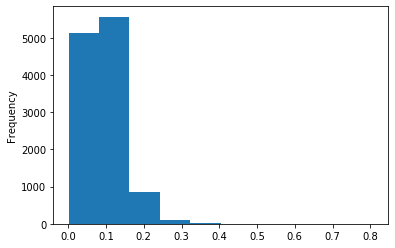

In [321]:
reviews_prod.dist.plot.hist()

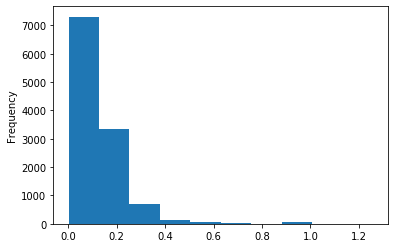

In [322]:
reviews_prod.dist_pos.plot.hist()

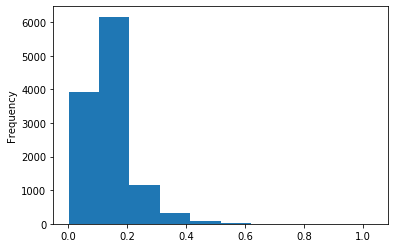

In [323]:
reviews_prod.dist_word.plot.hist()

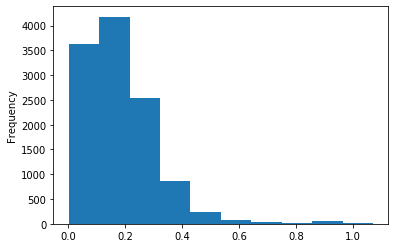

In [324]:
reviews_prod.dist_word_pos.plot.hist()

In [342]:
s_text

[['향', '좋은', '핸드크림']]

# Filtering

## category

In [299]:
cat_lst = reviews_prod.category.unique()

In [300]:
cat_lst

array(['비비크림', '메이크업', '바디워시', '클렌징', '데오도란트', '헤어/바디', '린스/컨디셔너',
       '헤어스타일링', '제모제/용품', '애프터쉐이브', '스크럽/필링', '쉐이빙', '마스크/팩', '로션', '스킨',
       '에센스', '크림', '선케어', '트러블케어', '미스트', '화이트닝케어', '링클케어', '수딩젤/팩',
       '바디로션', '베이비스킨케어', '모공케어', '바디크림', '수면팩', '토너/필링패드', '페이스오일',
       '바디오일', '바디밤/파우더', '메이크업픽서', '바디미스트', '클렌징폼', '베이비클렌저/샴푸', '워시오프',
       '클렌징젤', '클렌징오일', '클렌징밀크', '클렌징크림', '클렌징워터', '바디스크럽', '포인트리무버',
       '클렌징티슈', '클렌징비누', '목욕비누', '메이크업베이스', '선블록', '톤업크림', '베이스프라이머',
       '포인트프라이머', '파운데이션', '쿠션타입', '팩트', '씨씨크림', '컨실러', '하이라이터', '파우더',
       '트윈케익', '립스틱', '블러셔', '립글로스/락커', '립틴트', '립밤', '핸드케어', '립라이너',
       '아이라이너-펜슬&젤', '아이라이너-리퀴드', '마스카라', '픽서/영양제', '아이섀도우', '아이브로우-펜슬',
       '아이브로우-파우더', '아이브로우-마스카라&리퀴드', '쉐딩', '마스크시트', '필오프', '코팩',
       '베이비선케어', '선스프레이', '선스틱', '선쿠션', '태닝', '아이케어', '넥케어', '샴푸',
       '베이비바디', '바디슬리밍', '아로마테라피', '바디에센스', '풋케어', '입욕제', '트리트먼트/팩',
       '헤어에센스', '헤어소품', '염색제/퍼머제', '헤어기기', '네일컬러', '네일아트/소품', '네일영양',
       '네일리무버', '소형

In [301]:
# 추출된 키워드가 카테고리 내에 있으면 걔네만 추천

inter_cat = []
for cat in cat_lst:
    for s in s_text[0]:
        if s in cat:
            inter_cat.append(cat)

In [302]:
if len(inter_cat) > 0:
    reviews_prod = reviews_prod[reviews_prod.category.isin(inter_cat)]

In [303]:
print('reviews_prod.shape: ',reviews_prod.shape)

reviews_prod.shape:  (614, 18)


## product name

In [326]:
s_dict = {
    #메이크업항목
    'makeup_dict':{
#     '비비':['BB','파운데이션','듀얼 스틱','원 플루이드 그린','저스트 스킨','모이스처라이저 B'],
    '톤업':['톤 업','톤 매너','아프리카 버드 옴므 올인원 브라이트닝 에센스'],
#     '씨씨':['CC','CC크림','리얼컴플렉션 젤 피니셔','포맨 히든스틱'],
#     '쿠션':['쿠션크림'],
#     '립':['밤','듀얼 스틱'],
#     '브로우':['눈썹','마스터 커버스틱','숯 유어셀프'],
    },

    #헤어/바디 항목
    'hair_body_dict':{
#     '바디워시':['워시','바디 워시','비어 원샷 클렌저 포맨','맨즈 시트러스 민트 3 IN 1'],
#     '샴푸':['방 덴시피크 옴므','두쉐르 베제딸 뿌르옴므','또니끄 비비휘앙 뿌르옴므','뱅 떼에스 뿌르옴므','뱅 트레땅 알라 프로폴리스 뿌르옴므'],
    '샤워젤':['샤워','샤워 젤'],
    '스프레이':['퍼퓸건','미스트','라스트 샷'],
#     '로션':['크림','핸드크림','핸드','맨올로지 101 에너자이징 바디 에멀젼'],
    '데오드란트':['데오도란트','맨 블랙 앤 화이트 롤 온','매너 키트','데오도런트'],
    '오일':['맨 퓨어-포먼스 컴포지션']
    },

    #헤어스타일링 항목 
    'hairstyle_dict':{
    '왁스':['무빙러버','젤','하드','헤어잼','크래프트 클레이 리모델러블 매트 텍스처라이저','알앤비','포맨 오리지널 슈퍼 매트','버번 바닐라 & 텐저린 헤어 텍스처라이저','맨 퓨어-포먼스 그루밍 클레이'],
#     '컬':['볼륨미아 볼륨 무스']
    }
}

In [327]:
inter_word = []
for cat, dic in s_dict.items():
    for k, v in dic.items():
        if k in s_text[0]:
            inter_word = v
            continue
        for i in v:
            if i in s_text[0]:
                inter_word = v

In [328]:
if len(inter_word) > 0:
    inter_idx = []
    for i, p in enumerate(reviews_prod['product']):
        for c in inter_word:
            if c in p:
                inter_idx.append(i)
    reviews_prod = reviews_prod.iloc[inter_idx]

In [329]:
print('len(inter_idx): ', len(inter_idx))

len(inter_idx):  0


In [330]:
print('reviews_prod.shape: ',reviews_prod.shape)

reviews_prod.shape:  (11667, 18)


## nb_reviews

In [331]:
def repl(x):
    pattern = '[^\d]'
    return re.sub(pattern, '', x)

In [332]:
reviews_prod.nb_reviews = reviews_prod.nb_reviews.map(repl).astype(int)

In [333]:
nb_reviews_med = reviews_prod.nb_reviews.describe().loc['50%']

In [334]:
reviews_prod = reviews_prod[reviews_prod.nb_reviews >= nb_reviews_med]

In [335]:
print('reviews_prod.shape: ',reviews_prod.shape)

reviews_prod.shape:  (5834, 18)


## rate

In [336]:
rate_dict = {
    'best':0,
    'good':1,
    'soso':2,
    'bad':3,
    'worst':4
}
reviews_prod.rate_x = reviews_prod.rate_x.map(rate_dict)

In [337]:
reviews_prod = reviews_prod[reviews_prod.rate_x.isin([0,1])]
print('reviews_prod.shape: ',reviews_prod.shape)

reviews_prod.shape:  (4320, 18)


# Recommander

In [338]:
f = set(s_text[0]) & set(cat_lst)
if len(f) > 0:
    temp = reviews_prod[['dist'] + features]
    temp = temp[temp.category.isin(f)].sort_values(by=['rate_x','dist']).drop_duplicates()
else:
    temp = reviews_prod[['dist'] + features].sort_values(by=['rate_x','dist']).drop_duplicates()
temp[show_features + ['content']].head()

,category,brand,nb_reviews,vol_price,product,content
7173,미스트,보타닉힐 보 (boH),708,"120ml15,000원",더마 인텐시브 판테놀 크림 미스트,나오는 것도 좋고 가성비가 좋은 제품이군요! 크림향도 나는거같고 촉촉하네요~
10132,핸드케어,이솝 (Aesop),237,"75ml30,000원",레저렉션 아로마틱 핸드 밤,핸드크림중에 제일 좋은거 같아요 은은한 우드향이라 과하지 않고 좋아요!
9147,수딩젤/팩,아로마티카 (AROMATICA),1538,"300ml11,000원",95% 유기농 알로에 베라 젤,진짜 좋아요! 피부에 무리도 없고 믿을만한 제품인것 같아요!
4354,로션,이니스프리 (innisfree),59,"120ml22,000원",포레스트 포맨 모이스처 로션,남자친구 선물해줬는데 좋아해요ㅎㅎ 무난하니 가격도그렇고 선물하기 좋은것같아요ㅎ
9152,수딩젤/팩,토니모리 (TONYMOLY),144,"250ml3,300원",알로에 99% 촉촉 수딩젤,이거만큼 저렴하구 좋은 수딩젤 못봤습니당!


In [339]:
f = set(s_text[0]) & set(cat_lst)
if len(f) > 0:
    temp = reviews_prod[['dist_word'] + features]
    temp = temp[temp.category.isin(f)].sort_values(by=['rate_x','dist_word']).drop_duplicates()
else:
    temp = reviews_prod[['dist_word'] + features].sort_values(by=['rate_x','dist_word']).drop_duplicates()
temp[show_features + ['content']].head()

,category,brand,nb_reviews,vol_price,product,content
8160,파운데이션,바비브라운 (BOBBI BROWN),153,"30ml65,000원",스킨 롱웨어 웨이트리스 파운데이션 [SPF15/PA++],남자가 쓰기에 너무 좋은듯 한듯 안한듯하면서 커버력이 너무 좋음
5213,에센스,보타닉힐 보 아이디얼 포 맨 (ideal),139,"150ml28,000원",퍼펙트 올인원,향도없고 남자들이쓰기좋은거같아요! 발림성도좋고 땡기는거도 덜함!
7186,미스트,샤넬 (CHANEL),259,"50ml130,000원",보떼 이니샬 에너자이징 멀티 프로텍션 컨센트레이트 스프레이 쎄럼,좋은데 가격이ㅜㅠㅠㅠㅠ
10132,핸드케어,이솝 (Aesop),237,"75ml30,000원",레저렉션 아로마틱 핸드 밤,핸드크림중에 제일 좋은거 같아요 은은한 우드향이라 과하지 않고 좋아요!
7173,미스트,보타닉힐 보 (boH),708,"120ml15,000원",더마 인텐시브 판테놀 크림 미스트,나오는 것도 좋고 가성비가 좋은 제품이군요! 크림향도 나는거같고 촉촉하네요~


In [340]:
f = set(s_text[0]) & set(cat_lst)
if len(f) > 0:
    temp = reviews_prod[['dist_pos'] + features]
    temp = temp[temp.category.isin(f)].sort_values(by=['rate_x','dist_pos']).drop_duplicates()
else:
    temp = reviews_prod[['dist_pos'] + features].sort_values(by=['rate_x','dist_pos']).drop_duplicates()
temp[show_features + ['content']].head()

,category,brand,nb_reviews,vol_price,product,content
10193,풋케어,뉴트로지나 (Neutrogena),310,"56g8,000원",노르웨이젼 포뮬러 풋 크림,핸드크림 풋크림 차이 잘 모르겠지만 보습 충분해서 좋다
7173,미스트,보타닉힐 보 (boH),708,"120ml15,000원",더마 인텐시브 판테놀 크림 미스트,나오는 것도 좋고 가성비가 좋은 제품이군요! 크림향도 나는거같고 촉촉하네요~
9315,선블록,닥터아토 (Dr.ato),108,"50ml16,000원",수분 촉촉 데일리 선 로션 [SPF30/PA++],선크림바르면 막 하얗게 잘 뜨는 타입이라 제가 원래 진짜 너무 싫어했는데 얘는 색이...
9316,베이비선케어,닥터아토 (Dr.ato),108,"50ml16,000원",수분 촉촉 데일리 선 로션 [SPF30/PA++],선크림바르면 막 하얗게 잘 뜨는 타입이라 제가 원래 진짜 너무 싫어했는데 얘는 색이...
9419,선스틱,홀리카홀리카 (HOLIKA HOLIKA),121,"17g19,000원",알로에 워터톡 선스틱 [SPF50+/PA++++],제가 제일 선호하는 선스틱이나 선크림류 제품이에요! 아침에 저같은 경우는 시간이 적...


In [341]:
f = set(s_text[0]) & set(cat_lst)
if len(f) > 0:
    temp = reviews_prod[['dist_word_pos'] + features]
    temp = temp[temp.category.isin(f)].sort_values(by=['rate_x','dist_word_pos']).drop_duplicates()
else:
    temp = reviews_prod[['dist_word_pos'] + features].sort_values(by=['rate_x','dist_word_pos']).drop_duplicates()
temp[show_features + ['content']].head()

,category,brand,nb_reviews,vol_price,product,content
10193,풋케어,뉴트로지나 (Neutrogena),310,"56g8,000원",노르웨이젼 포뮬러 풋 크림,핸드크림 풋크림 차이 잘 모르겠지만 보습 충분해서 좋다
9656,화이트닝케어,이니스프리 (innisfree),189,"50ml20,000원",제주 왕벚꽃 젤리 크림,톤업크림이랑 같이 사용하고 있어요! 수분목적 보다는 톤업크림과 같이 쓴다는 용도 느낌?
9943,바디로션,록시땅 (LOCCITANE),73,"250ml42,000원",체리 블라썸 쉬머링 바디 로션,이거핸드로션도같이쓰는중인데...향도너무좋고 보습도너무좋다♥
8350,컨실러,"클레어스 (dear, klairs)",63,"6ml11,900원",크리미앤내추럴핏컨실러,비비크림으로 못가린 잡티 가릴때 좋음
7173,미스트,보타닉힐 보 (boH),708,"120ml15,000원",더마 인텐시브 판테놀 크림 미스트,나오는 것도 좋고 가성비가 좋은 제품이군요! 크림향도 나는거같고 촉촉하네요~
